In [5]:
# Load all the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openmeteo_requests
import requests_cache
from retry_requests import retry
import os
import time
import random
import seaborn as sns
from calendar import month
from scipy.stats import linregress

### Call the API, fetch the required data and create the dataframe

In [119]:
# create a data directory call Data for our data
os.makedirs("Data", exist_ok=True)
print(f"Folder Data created successfully!")

Folder Data created successfully!


In [120]:
# Declare the latitude and longitude for both cities
cities = {"Zurich": {'loc': ["47.3769", "8.5417"]},
		  "Toronto": {'loc': ["43.6532", "79.3832"]}}

In [121]:
# Setup the Open-Meteo API client with cache and retry on error 
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [122]:
def call_API(city, openmeteo):
    # Set the API call parameters
    # We set the location, date, variables and measurement units
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": cities[city]['loc'][0],
        "longitude": cities[city]['loc'][1],
        "start_date": "1940-01-01",
        "end_date": "2024-12-31",
        "daily": ["weather_code", "temperature_2m_max", "temperature_2m_min", "temperature_2m_mean",
                "apparent_temperature_max", "apparent_temperature_min", "apparent_temperature_mean", "sunrise",
                "sunset", "daylight_duration", "sunshine_duration", "precipitation_sum", "rain_sum", "snowfall_sum",
                "precipitation_hours", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant",
                "shortwave_radiation_sum", "et0_fao_evapotranspiration"],
        "timezone": cities[city].get('timezone', "Europe/Berlin"),
        "temperature_unit": "celsius",
        "wind_speed_unit": "kmh",
        "precipitation_unit": "mm"
    }
    responses = openmeteo.weather_api(url, params=params)

    # Print the first part of the API response to validate the call data is valid
    response = responses[0]
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")
   
    return response

In the create_dataframe function we validate the data types as we receive the data, we also change the date format into a readable format and into a format that useful for our project as we don't need anything but the date. This save us from performing these tasks later on when we clean our data.

In [123]:
def create_dataframe(response):
	# Process data and validate variable types
	daily = response.Daily()
	daily_weather_code = daily.Variables(0).ValuesAsNumpy()
	daily_temperature_2m_max = daily.Variables(1).ValuesAsNumpy()
	daily_temperature_2m_min = daily.Variables(2).ValuesAsNumpy()
	daily_temperature_2m_mean = daily.Variables(3).ValuesAsNumpy()
	daily_apparent_temperature_max = daily.Variables(4).ValuesAsNumpy()
	daily_apparent_temperature_min = daily.Variables(5).ValuesAsNumpy()
	daily_apparent_temperature_mean = daily.Variables(6).ValuesAsNumpy()
	daily_sunrise = daily.Variables(7).ValuesAsNumpy()
	daily_sunset = daily.Variables(8).ValuesAsNumpy()
	daily_daylight_duration = daily.Variables(9).ValuesAsNumpy()
	daily_sunshine_duration = daily.Variables(10).ValuesAsNumpy()
	daily_precipitation_sum = daily.Variables(11).ValuesAsNumpy()
	daily_rain_sum = daily.Variables(12).ValuesAsNumpy()
	daily_snowfall_sum = daily.Variables(13).ValuesAsNumpy()
	daily_precipitation_hours = daily.Variables(14).ValuesAsNumpy()
	daily_wind_speed_10m_max = daily.Variables(15).ValuesAsNumpy()
	daily_wind_gusts_10m_max = daily.Variables(16).ValuesAsNumpy()
	daily_wind_direction_10m_dominant = daily.Variables(17).ValuesAsNumpy()
	daily_shortwave_radiation_sum = daily.Variables(18).ValuesAsNumpy()
	daily_et0_fao_evapotranspiration = daily.Variables(19).ValuesAsNumpy()
	
	# Format the date variable to readable and usable format
	daily_data = {"date": pd.date_range(
		start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
		end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = daily.Interval()),
		inclusive = "left"
		).strftime('%Y/%m/%d')
	}
	
	# Create the pandas dataframe
	daily_data["weather_code"] = daily_weather_code
	daily_data["temperature_2m_max"] = daily_temperature_2m_max
	daily_data["temperature_2m_min"] = daily_temperature_2m_min
	daily_data["temperature_2m_mean"] = daily_temperature_2m_mean
	daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
	daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
	daily_data["apparent_temperature_mean"] = daily_apparent_temperature_mean
	daily_data["sunrise"] = daily_sunrise
	daily_data["sunset"] = daily_sunset
	daily_data["daylight_duration"] = daily_daylight_duration
	daily_data["sunshine_duration"] = daily_sunshine_duration
	daily_data["precipitation_sum"] = daily_precipitation_sum
	daily_data["rain_sum"] = daily_rain_sum
	daily_data["snowfall_sum"] = daily_snowfall_sum
	daily_data["precipitation_hours"] = daily_precipitation_hours
	daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max
	daily_data["wind_gusts_10m_max"] = daily_wind_gusts_10m_max
	daily_data["wind_direction_10m_dominant"] = daily_wind_direction_10m_dominant
	daily_data["shortwave_radiation_sum"] = daily_shortwave_radiation_sum
	daily_data["et0_fao_evapotranspiration"] = daily_et0_fao_evapotranspiration
	
	# Make a dataframe from the dictionary
	daily_dataframe = pd.DataFrame(data = daily_data)
	
	return daily_dataframe

In [124]:
def save_df(data, city):
	# Save the dataframe of the city as csv file
	data.to_csv(f"Data/{city}.csv", index = False)
	print(f"Saved data for '{city}' successfully!")

In [126]:
# Call the API and save the data as csv files
# Saving to csv files to limit the amount of calls to data provider
count = 0
for city in cities:
    response = call_API(city, openmeteo)
    data = create_dataframe(response)
    save_df(data, city)
    print('\n')

    # Delay the 2nd API call for 2 minutes to not violate limits on API calls 
    if count < 1:
        print("\n Taking a 2 minute break, please be patient........ ")
        print("\n")
        time.sleep(120)
    count += 1

Coordinates 47.34621810913086°N 8.54337215423584°E
Elevation 409.0 m asl
Timezone b'Europe/Berlin' b'GMT+2'
Timezone difference to GMT+0 7200 s
Saved data for 'Zurich' successfully!



 Taking a 2 minute break, please be patient........ 
Coordinates 43.620384216308594°N 79.4277114868164°E
Elevation 640.0 m asl
Timezone b'Europe/Berlin' b'GMT+2'
Timezone difference to GMT+0 7200 s
Saved data for 'Toronto' successfully!




### Clean the dataset
Some of the data cleaning was preformed when we received the data from the API calls as it was deemed a more effiecent. 

In [127]:
# Create a single dataframe from the 2 datasets
# Load the 2 datasets
df1 = pd.read_csv("Data/Zurich.csv")
df2 = pd.read_csv("Data/Toronto.csv")

# Add a column to contains the city name
df1['city'] = 'Zurich'
df2['city'] = 'Toronto'

In [128]:
# Concatenate the 2 dataframes
df = pd.concat([df1, df2], ignore_index=True)

In [129]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [130]:
# Check for empty or all zeros columns
empty_cols = []
for col in numerical_cols:
	if df[col].sum() == 0:
		empty_cols.append(col)
		
print(empty_cols)

['sunrise', 'sunset']


In [131]:
# Remove two columns with only zero values
df = df.drop(empty_cols, axis=1)

In [132]:
# Get index of rows with NaN values
nan_rows = df[df.isna().any(axis=1)].index.tolist()

print(nan_rows)

[0, 31047]


In [133]:
df = df.drop(index=nan_rows, axis=0)

In [134]:
# See if the column is the correct data type
set(df.weather_code.unique())

{np.float64(0.0),
 np.float64(1.0),
 np.float64(2.0),
 np.float64(3.0),
 np.float64(51.0),
 np.float64(53.0),
 np.float64(55.0),
 np.float64(61.0),
 np.float64(63.0),
 np.float64(65.0),
 np.float64(71.0),
 np.float64(73.0),
 np.float64(75.0)}

In [4]:
# Change float to int
df['weather_code'] = df['weather_code'].astype(int)

In [136]:
# Write cleaned dataframe to csv file to limit API calls
df.to_csv("Data/clean.csv", index = False)

### Check the dataset for outliers

In [45]:
# Read the csv file
df = pd.read_csv("Data/clean.csv")

# Ensure datetime index
df.index = pd.DatetimeIndex(df.date)

In [46]:
# Identify remaining numerical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

In [47]:
# Find outliers for each column
outlier_results = []

for col in num_cols:
    # Calculate quartiles
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = len(outliers)
    
    # Only inspect 
    if num_outliers > 0:
        outlier_results.append({
            'Column': col,
            'Outliers Count': num_outliers,
            'Min': df[col].min(),
            'Q1': Q1,
            'Median': df[col].median(),
            'Q3': Q3,
            'Max': df[col].max(),
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound
        })

# Create DataFrame with outlier results
outlier_df = pd.DataFrame(outlier_results)
print("\nOutlier Summary:")
print(outlier_df)


Outlier Summary:
                        Column  Outliers Count    Min    Q1  Median    Q3  \
0           temperature_2m_max               3 -21.27  6.80   15.42 23.66   
1           temperature_2m_min              54 -31.07 -1.14    5.77 13.01   
2          temperature_2m_mean              11 -25.35  2.57   10.63 18.34   
3     apparent_temperature_min              34 -35.93 -4.84    3.05 11.80   
4    apparent_temperature_mean               4 -30.19 -1.00    8.08 17.24   
5            precipitation_sum           10056   0.00  0.00    0.00  1.30   
6                     rain_sum           10412   0.00  0.00    0.00  1.00   
7                 snowfall_sum            6302   0.00  0.00    0.00  0.00   
8          precipitation_hours            5056   0.00  0.00    0.00  6.00   
9           wind_speed_10m_max            1884   1.44  9.26   13.36 19.67   
10          wind_gusts_10m_max            1399   7.56 21.96   29.88 41.40   
11  et0_fao_evapotranspiration             513   0.12  0.9

In [48]:
# Get the variables that have the most outliers
outlier_col = list(outlier_df[outlier_df['Outliers Count'] > 1000].Column)

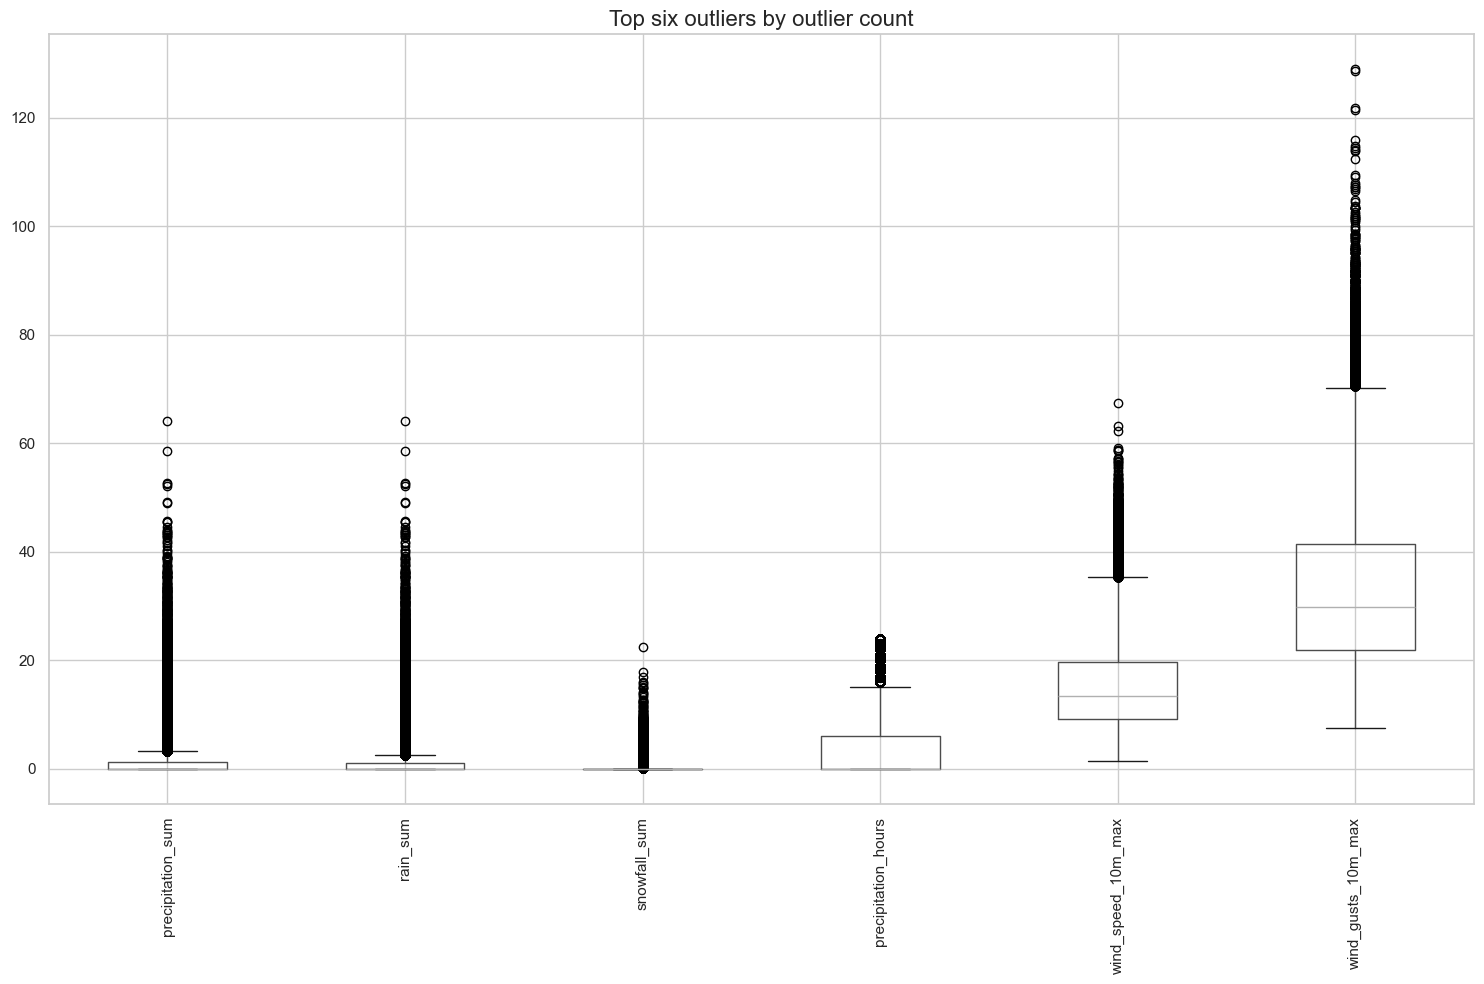

In [49]:
# Create box plots to inspect the top outliers
plt.figure(figsize=(15, 10))
df.boxplot(column=list(outlier_col), figsize=(15, 10))
plt.xticks(rotation=90)
plt.title('Top six outliers by outlier count')
plt.tight_layout()
plt.show()

After investagting the dataset for outliers it has become clear that the dataset does have outliers, but these outliers does fall under the expected behavior for weather patterns and in most cases represents extreme weather events, while in other cases the outliers represent weather events that don't occur frequently. For example is snows infrequently in Zurich and Toronto making a day with snow an outlier, the same holds for almost all weather varaibles.

### Working with missing data

Because the data is to clean and has no missing data, we am going to create missing data and the demonstrate how to deal with missing data, by randomly removing data from the dataset

In [142]:
df_mis = pd.read_csv("Data/clean.csv")

In [143]:
# Generate 1000 random numbers that represents the rows to apply missing values
random_numbers = [random.randint(1, len(df_mis)) for _ in range(1000)]

In [144]:
# Get a list of all the column names
columns = list(df_mis.columns)

# Remove date and city from the list
columns.remove('date')
columns.remove('city')

In [145]:
# Randomly apply NaN values to the columns and rows
for num in random_numbers:
	for col in columns:
		if random.choice([0, 1]) == 1:
			df_mis.loc[num, col] = np.nan

In [146]:
# Check the extend of the missing data
print(df_mis.isna().sum())

date                             0
weather_code                   503
temperature_2m_max             472
temperature_2m_min             464
temperature_2m_mean            493
apparent_temperature_max       510
apparent_temperature_min       506
apparent_temperature_mean      499
daylight_duration              482
sunshine_duration              516
precipitation_sum              495
rain_sum                       521
snowfall_sum                   487
precipitation_hours            488
wind_speed_10m_max             511
wind_gusts_10m_max             499
wind_direction_10m_dominant    488
shortwave_radiation_sum        516
et0_fao_evapotranspiration     468
city                             0
dtype: int64


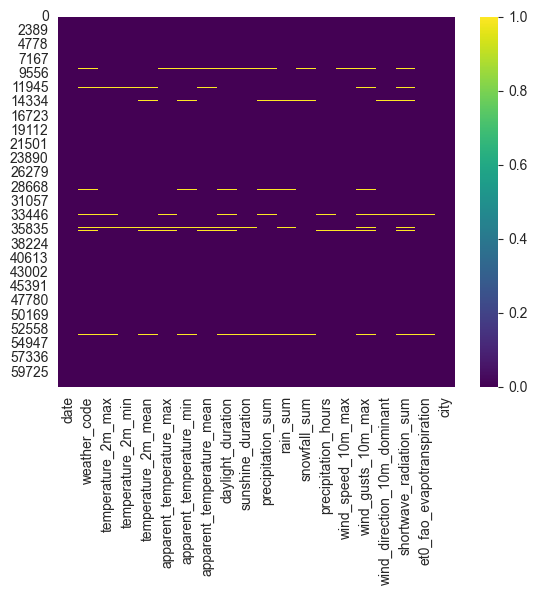

In [147]:
# Plot a heat map for missing values
sns.heatmap(df_mis.isnull(), cbar=True, cmap='viridis')
plt.show()

In [148]:
# Fill missing values with interpolation
df_filled = df_mis[columns].interpolate(method='linear')

In [149]:
# Check if there is still missing values
print(df_filled.isna().sum())

weather_code                   0
temperature_2m_max             0
temperature_2m_min             0
temperature_2m_mean            0
apparent_temperature_max       0
apparent_temperature_min       0
apparent_temperature_mean      0
daylight_duration              0
sunshine_duration              0
precipitation_sum              0
rain_sum                       0
snowfall_sum                   0
precipitation_hours            0
wind_speed_10m_max             0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
shortwave_radiation_sum        0
et0_fao_evapotranspiration     0
dtype: int64


We where able to succesfully interpolate our missing values. We used linear interpolation as it is a good choice for filling missing weather data. When applied to time series data like weather measurements, linear interpolation works by drawing a straight line between the nearest available data points on either side of the missing value, which is particularly effective for gradual changes that typically occur in weather patterns as it preserves the overall trends in the data while filling gaps.

## Research Question 1

## Research Question 2
#### How do the weather seasonal attributes of Zurich and Toronto compare?
We chose Zürich and Toronto to compare, as they are located quite far from any coastal areas and are in close proximity in terms of latitude. Both cities also have large lakes as well as a major mountain range nearby, making them, in our opinion, ideal for comparison. This allows us to observe how their weather and seasonal patterns differ, considering their similarities and the fact that they are located on different continents at similar lattitudes.

In [6]:
# Create the dataframe
df = pd.read_csv("Data/clean.csv")

# Ensure datetime index
df.index = pd.DatetimeIndex(df.date)

In [7]:
# Separate Zurich and Toronto data and set the date as index
Zurich_data = df[df['city'] == 'Zurich'].set_index('date')
Toronto_data = df[df['city'] == 'Toronto'].set_index('date')

# Merge the dataframes on date
merged_df = Zurich_data.merge(Toronto_data, on='date', suffixes=('_Zurich', '_Toronto'))

# Drop redundant city columns
merged_df = merged_df.drop(['city_Zurich', 'city_Toronto'], axis=1)

# Ensure the dataframe index is of type datetime
merged_df.index = pd.DatetimeIndex(merged_df.index)

# Create a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # 9, 10, 11
        return 'Fall'

# Add season column more efficiently
merged_df['season'] = merged_df.index.month.map(get_season)

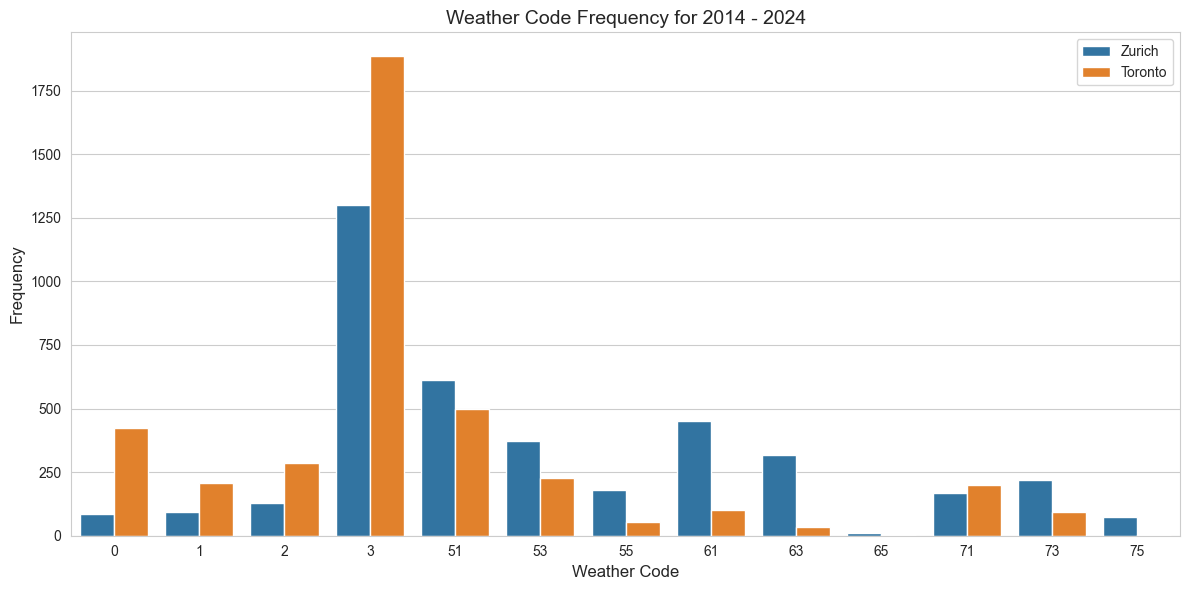

In [8]:
# Compare 10 years of data
ten_df = merged_df[merged_df.index >= '2014-01-01']

# Create comparison dataframe more efficiently
Zurich_counts = ten_df['weather_code_Zurich'].value_counts().sort_index()
Toronto_counts = ten_df['weather_code_Toronto'].value_counts().sort_index()

# Compare weather codes between cities
plt.figure(figsize=(12, 6))

# Combine into a single dataframe for plotting
comparison_df = pd.DataFrame({
    'Zurich': Zurich_counts,
    'Toronto': Toronto_counts
}).reset_index().melt(
    id_vars='index',
    value_vars=['Zurich', 'Toronto'],
    var_name='City',
    value_name='Frequency'
)

# Create a cleaner bar plot
ax = sns.barplot(x='index', y='Frequency', hue='City', data=comparison_df)

# Enhance the plot with better formatting
plt.title('Weather Code Frequency for 2014 - 2024', fontsize=14)
plt.xlabel('Weather Code', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='')
plt.tight_layout()
plt.show()

The weather codes is called OWM codes
- 0: Cloud development not observed or not observable
- 1: Clouds generally dissolving or becoming less developed
- 2: State of sky on the whole unchanged
- 3: Clouds generally forming or developing
- 51: Drizzle, not freezing, continuous, slight at time of observation
- 53: Drizzle, not freezing, continuous, moderate at time of observation
- 55: Drizzle, not freezing, continuous, heavy at time of observation
- 61: Rain, not freezing, continuous, slight at time of observation
- 63: Rain, not freezing, continuous, moderate at time of observation
- 65: Rain, not freezing, continuous, heavy at time of observation
- 71: Continuous fall of snowflakes, slight at time of observation
- 73: Continuous fall of snowflakes, moderate at time of observation
- 75: Continuous fall of snowflakes, heavy at time of observation  
[Source](https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM)

By looking at the weather codes it is clear that both cities have predominantly cloudy weather (code 3). Zurich also receives more presperation than Toronto in terms of both rain and snow, in turn Toronto has more sunny days than Zürich. 

As these weather codes are based on obervations at the time of the observation we don't want to over analyse them as we think our other numerical weather variable will provide more accurate insights.


## Ambient and Apparent Temperature Seasonal Comparison 

In [9]:
# Define the season order for consistent presentation
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

# Identify numeric columns
numeric_cols = merged_df.select_dtypes(include=['number']).columns
for col in numeric_cols:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Now get seasonal averages, excluding weather code columns
season_stats = merged_df.drop(['weather_code_Zurich', 'weather_code_Toronto'], axis=1).groupby('season').mean(numeric_only=True)

# Reorder seasons for better visualization
season_stats = season_stats.reindex(season_order)

# Use temperature columns
temp_columns = [
    'temperature_2m_mean_Zurich', 'temperature_2m_mean_Toronto',
    'apparent_temperature_mean_Zurich', 'apparent_temperature_mean_Toronto'
]

# Create a dataframe in tidy format
temp_data = []
for column in temp_columns:
    city = 'Zurich' if 'Zurich' in column else 'Toronto'
    temp_type = 'Ambient' if 'temperature_2m' in column else 'Apparent' 
    
    for season in season_order:
        if column in season_stats.columns:  # Make sure the column exists
            temp_value = season_stats.loc[season, column]
            temp_data.append({
                'Season': season,
                'City': city,
                'Type': temp_type,
                'Temperature': temp_value
            })

temp_df = pd.DataFrame(temp_data)

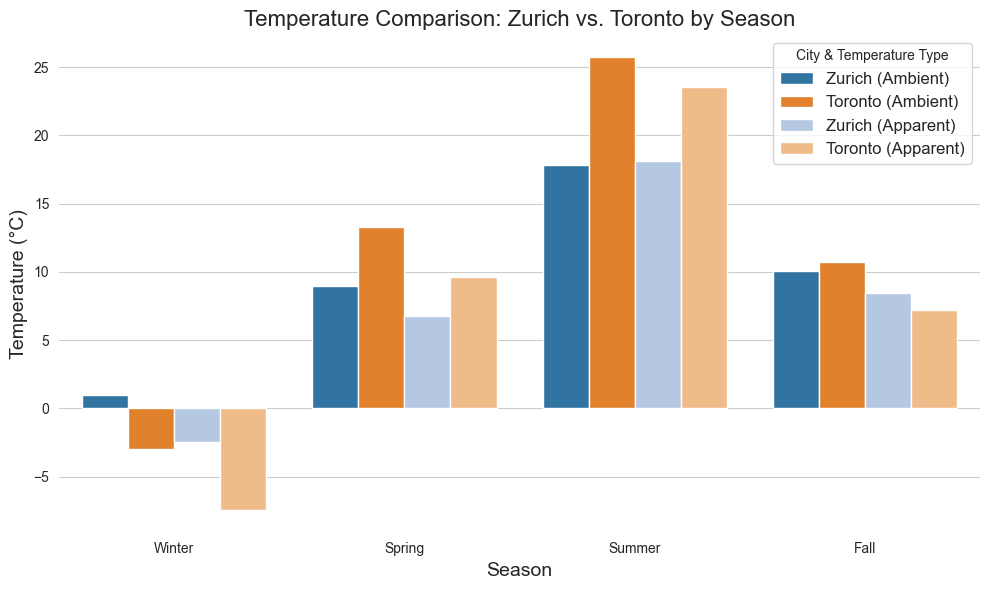

In [22]:
# Create a more informative and visually appealing temperature comparison
plt.figure(figsize=(10, 6))

# Add a column combining city and temperature
temp_df['City_Type'] = temp_df['City'] + ' (' + temp_df['Type'] + ')'

# Define a better color palette
custom_palette = {
    'Zurich (Ambient)': '#1f77b4',      # Darker blue
    'Zurich (Apparent)': '#aec7e8',  # Lighter blue
    'Toronto (Ambient)': '#ff7f0e',      # Darker orange
    'Toronto (Apparent)': '#ffbb78'  # Lighter orange
}

# Create an enhanced bar plot
sns.barplot(
    data=temp_df,
    x='Season',
    y='Temperature',
    hue='City_Type',
    palette=custom_palette
)

# Add plot details for better clarity
plt.title('Temperature Comparison: Zurich vs. Toronto by Season', fontsize=16)
plt.xlabel('Season', fontsize=14)
plt.ylabel('Temperature (°C)', fontsize=14)
plt.legend(title='City & Temperature Type', fontsize=12)

# Remove unnecessary chart elements
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

Apparent Temperature refers to how hot or cold the air feels to the human body, rather than the actual air temperature measured by a thermometer. It combines the effects of several environmental factors such air temperature, humitidy and wind speed.

Toronto has higher temperatures than Zurich during the spring and summer periods, while both cities have similar temperatures during the fall. Toronto has colder winters than Zürich which would indicate that Toranto has a bigger variation in temperatures during a year. What is also insteresting is that Toronto has a bigger variance between it's ambient temperatures and apparent temperatures than Zürich. With Zürich almost having no variance during the summer.

## Daylight vs Sunshine Ratio

In [11]:
# Extract month from the datetime index
merged_df['month'] = merged_df.index.month

# Create month names for better readability
month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
               7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
merged_df['month_name'] = merged_df['month'].map(month_names)

# Calculate sunshine ratio for both cities
merged_df['sunshine_ratio_Zurich'] = merged_df['sunshine_duration_Zurich'] / merged_df['daylight_duration_Zurich']
merged_df['sunshine_ratio_Toronto'] = merged_df['sunshine_duration_Toronto'] / merged_df['daylight_duration_Toronto']

# Group by month and calculate average sunshine ratio for each month
monthly_sunshine = merged_df.groupby('month_name').agg({
    'sunshine_ratio_Zurich': 'mean',
    'sunshine_ratio_Toronto': 'mean'
}).reset_index()

# Sort by month
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_sunshine['month_name'] = pd.Categorical(monthly_sunshine['month_name'], categories=month_order, ordered=True)
monthly_sunshine = monthly_sunshine.sort_values('month_name')

In [12]:
# Reshape data
sunshine_melted = pd.melt(monthly_sunshine, 
                          id_vars=['month_name'],
                          value_vars=['sunshine_ratio_Zurich', 'sunshine_ratio_Toronto'],
                          var_name='city', 
                          value_name='sunshine_ratio')

# Clean up city names for legend
sunshine_melted['city'] = sunshine_melted['city'].map({
    'sunshine_ratio_Zurich': 'Zurich',
    'sunshine_ratio_Toronto': 'Toronto'
})

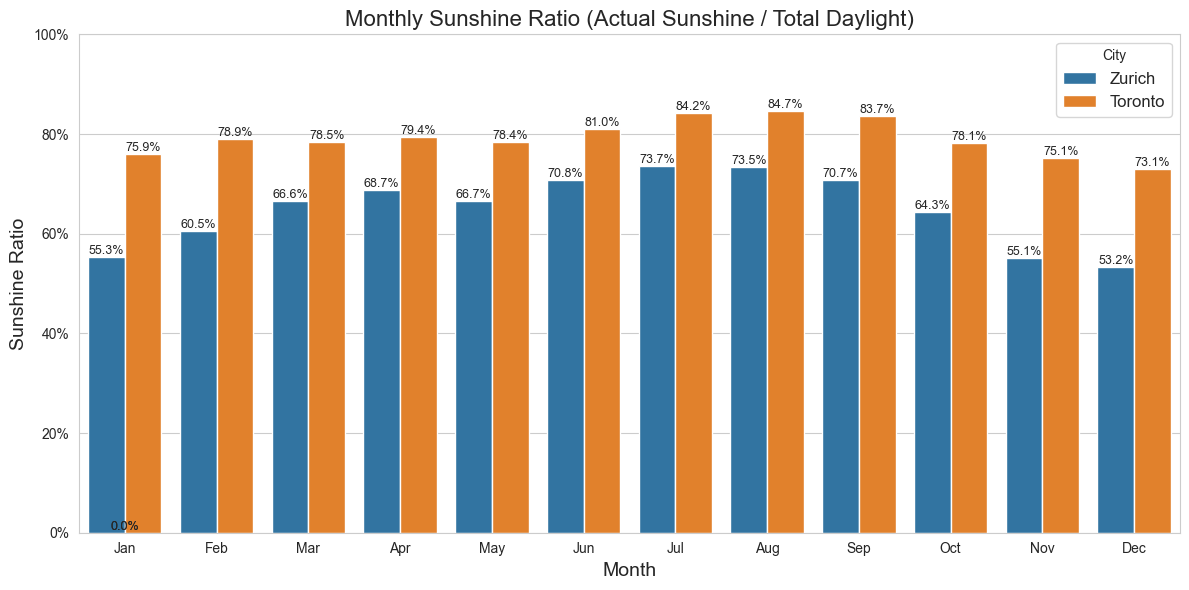

In [13]:
# Create bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='month_name', y='sunshine_ratio', hue='city', data=sunshine_melted)

# Add titles and labels
plt.title('Monthly Sunshine Ratio (Actual Sunshine / Total Daylight)', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Sunshine Ratio', fontsize=14)
plt.ylim(0, 1.0)  # Set y-axis from 0 to 1 (0-100%)

# Format y-axis as percentage
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

# Add annotations for each bar to show the exact percentage
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1%}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)

plt.legend(title='City', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

The sunshine ratio represents what percentage of available daylight hours actually receive sunshine. It's calculated by dividing the sunshine duration by the total daylight duration for each day, then averaging by month.

Toronto has a higher annual sunshine ratio compared to Zurich. Both cities have their lowest sunshine ratios during winter, but Toronto is significantly higher. Both cities enjoy their highest sunshine ratios in summer. Spring and Fall has very similar sunshine ratios for both cities. The best months are July and August for both Toronto and Zurich, with the biggest difference occuring in December and January, where Toronto has a much higher sunshine ratio than Zurich. Toronto shows more consistent sunshine ratios throughout the year, with less extreme seasonal variation than Zurich.

The sunshine ratios we see here feels contratictary to our findings in the weather codes but if take into consideration factors like it raining or snowing during the night or just for a period during the day time, our findings makes more sense.

## Shortwave Raditiation and Solar Energy

In [14]:
# Calculate monthly averages
zurich_monthly = merged_df.groupby('month_name')['shortwave_radiation_sum_Zurich'].mean().reset_index()
toronto_monthly = merged_df.groupby('month_name')['shortwave_radiation_sum_Toronto'].mean().reset_index()

# Convert month names to categorical with the correct order
zurich_monthly['month_name'] = pd.Categorical(zurich_monthly['month_name'], categories=month_order, ordered=True)
toronto_monthly['month_name'] = pd.Categorical(toronto_monthly['month_name'], categories=month_order, ordered=True)

# Sort by month
zurich_monthly = zurich_monthly.sort_values('month_name')
toronto_monthly = toronto_monthly.sort_values('month_name')

# Combine the data for plotting
monthly_radiation = pd.DataFrame({
    'Month': zurich_monthly['month_name'],
    'Zurich': zurich_monthly['shortwave_radiation_sum_Zurich'],
    'Toronto': toronto_monthly['shortwave_radiation_sum_Toronto']
})

# Reshape data for seaborn
radiation_melted = pd.melt(
    merged_df,
    id_vars=['month_name'],
    value_vars=['shortwave_radiation_sum_Zurich', 'shortwave_radiation_sum_Toronto'],
    var_name='City',
    value_name='Shortwave Radiation (MJ/m²)'
)

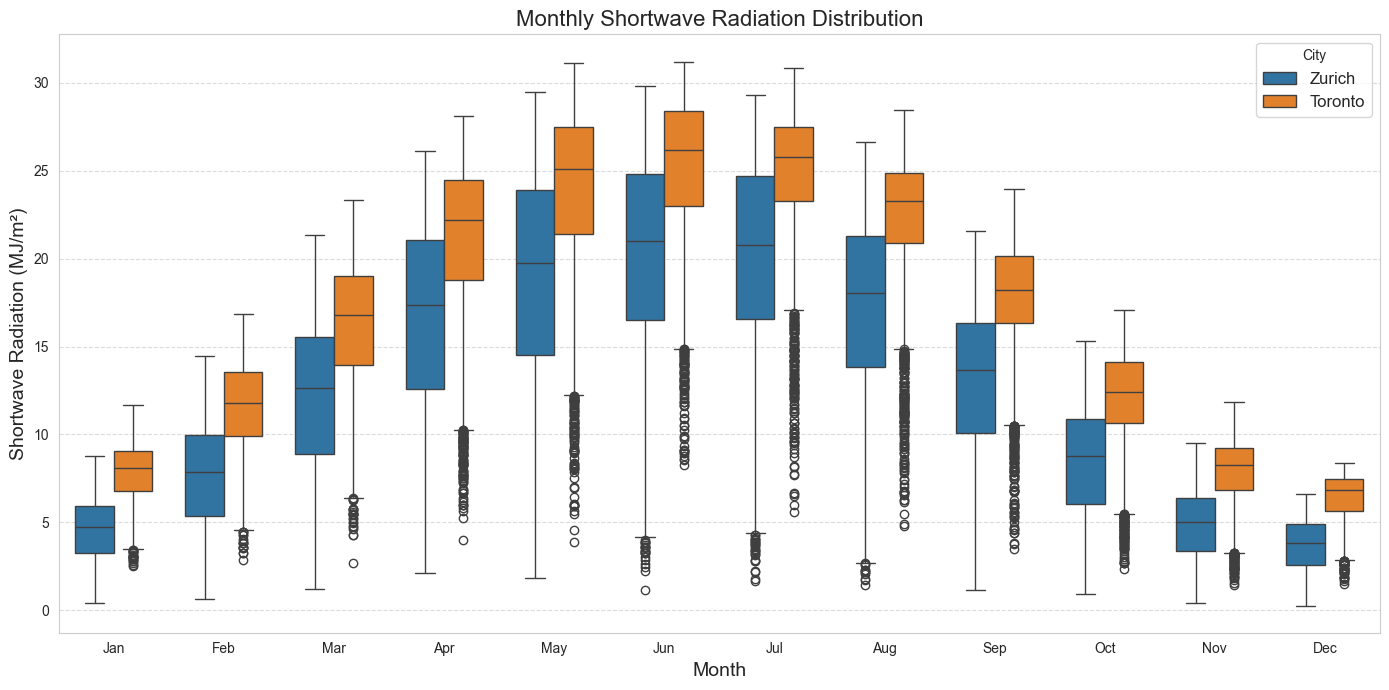

In [15]:
# Clean up city names by removing the prefix
radiation_melted['City'] = radiation_melted['City'].str.replace('shortwave_radiation_sum_', '')

# Convert month names to categorical with the correct order
radiation_melted['month_name'] = pd.Categorical(radiation_melted['month_name'], 
                                               categories=month_order, 
                                               ordered=True)

# Sort by month
radiation_melted = radiation_melted.sort_values('month_name')

# Plot monthly comparison with boxplot
plt.figure(figsize=(14, 7))
ax = sns.boxplot(
    data=radiation_melted,
    x='month_name',
    y='Shortwave Radiation (MJ/m²)',
    hue='City',
    palette=['#1f77b4', '#ff7f0e'],
    width=0.7
)

plt.title('Monthly Shortwave Radiation Distribution', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Shortwave Radiation (MJ/m²)', fontsize=14)
plt.legend(title='City', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Both cities show similar seasonal patterns with peak radiation in summer months, with Toronto consistently receives more shortwave radiation than Zurich throughout the year.


In [16]:
# Typical solar panel efficiency
efficiency = 0.18

# Convert MJ/m2 to kWh/m2
# 1 MJ = 0.2778 kWh
zurich_kwh_per_m2 = zurich_monthly['shortwave_radiation_sum_Zurich'] * 0.2778
toronto_kwh_per_m2 = toronto_monthly['shortwave_radiation_sum_Toronto'] * 0.2778

# Calculate potential electricity generation with solar panels
zurich_potential = zurich_kwh_per_m2 * efficiency
toronto_potential = toronto_kwh_per_m2 * efficiency

# Create dataframe for plotting
potential_df = pd.DataFrame({
    'Month': month_order,
    'Zurich': zurich_potential.values,
    'Toronto': toronto_potential.values
})

# Reshape data for seaborn
potential_melted = pd.melt(
    potential_df,
    id_vars=['Month'],
    value_vars=['Zurich', 'Toronto'],
    var_name='City',
    value_name='Potential Solar Generation (kWh/m2)'
)

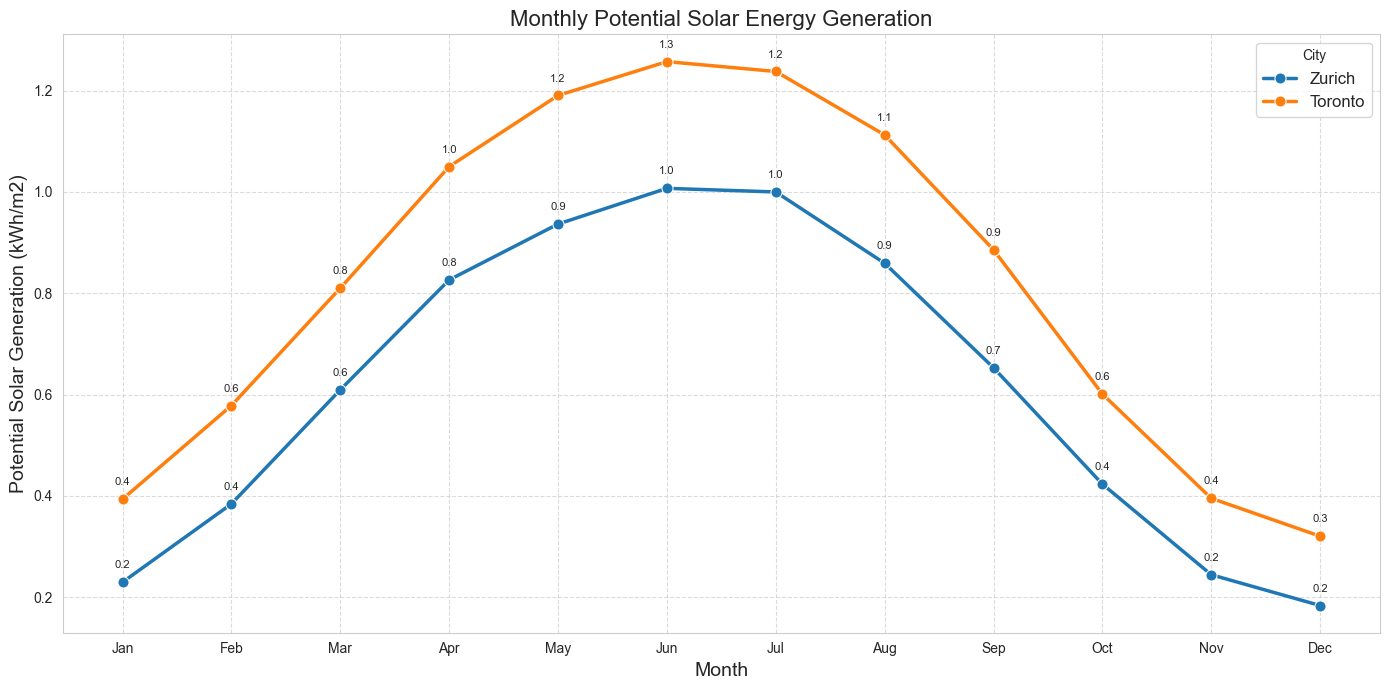

In [17]:
# Plot potential solar generation
plt.figure(figsize=(14, 7))
ax = sns.lineplot(
    data=potential_melted,
    x='Month',
    y='Potential Solar Generation (kWh/m2)',
    hue='City',
    marker='o',
    linewidth=2.5,
    markersize=8
)

plt.title('Monthly Potential Solar Energy Generation', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Potential Solar Generation (kWh/m2)', fontsize=14)
plt.legend(title='City', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add values on the line points
for i, city in enumerate(['Zurich', 'Toronto']):
    city_data = potential_melted[potential_melted['City'] == city]
    for x, y in zip(city_data.index % 12, city_data['Potential Solar Generation (kWh/m2)']):
        ax.annotate(f'{y:.1f}',
                   (x, y),
                   textcoords="offset points",
                   xytext=(0, 10),
                   ha='center',
                   fontsize=8)

plt.tight_layout()
plt.show()

Using a typical solar panel efficiency of 18%, the code calculates potential electricity generation. Toronto shows higher potential generation in all months.  
[Source](https://www.photonicuniverse.com/en/resources/articles/full/7.html)  

In Toronto solar energy generation would be higher despite both cities being at similar latitudes.  
[Source](https://www.sunbasedata.com/blog/how-to-calculate-solar-panel-output)

## Total Precipitation: Rain vs. Snowfall

In [18]:
# Calculate seasonal precipitation averages for each city
seasonal_precip = merged_df.groupby('season').agg({
    'rain_sum_Zurich': 'mean',
    'snowfall_sum_Zurich': 'mean',
    'rain_sum_Toronto': 'mean',
    'snowfall_sum_Toronto': 'mean',
    'precipitation_sum_Zurich': 'mean',
    'precipitation_sum_Toronto': 'mean'
}).reindex(season_order)

# Create dataframes for each city in a format suitable for stacked bar charts
zurich_precip = pd.DataFrame({
    'Season': seasonal_precip.index,
    'Rain': seasonal_precip['rain_sum_Zurich'],
    'Snow': seasonal_precip['snowfall_sum_Zurich'],
    'Total': seasonal_precip['precipitation_sum_Zurich']
})

toronto_precip = pd.DataFrame({
    'Season': seasonal_precip.index,
    'Rain': seasonal_precip['rain_sum_Toronto'],
    'Snow': seasonal_precip['snowfall_sum_Toronto'],
    'Total': seasonal_precip['precipitation_sum_Toronto']
})

# Calculate percentages
for df in [zurich_precip, toronto_precip]:
    df['Rain_pct'] = df['Rain'] / df['Total'] * 100
    df['Snow_pct'] = df['Snow'] / df['Total'] * 100

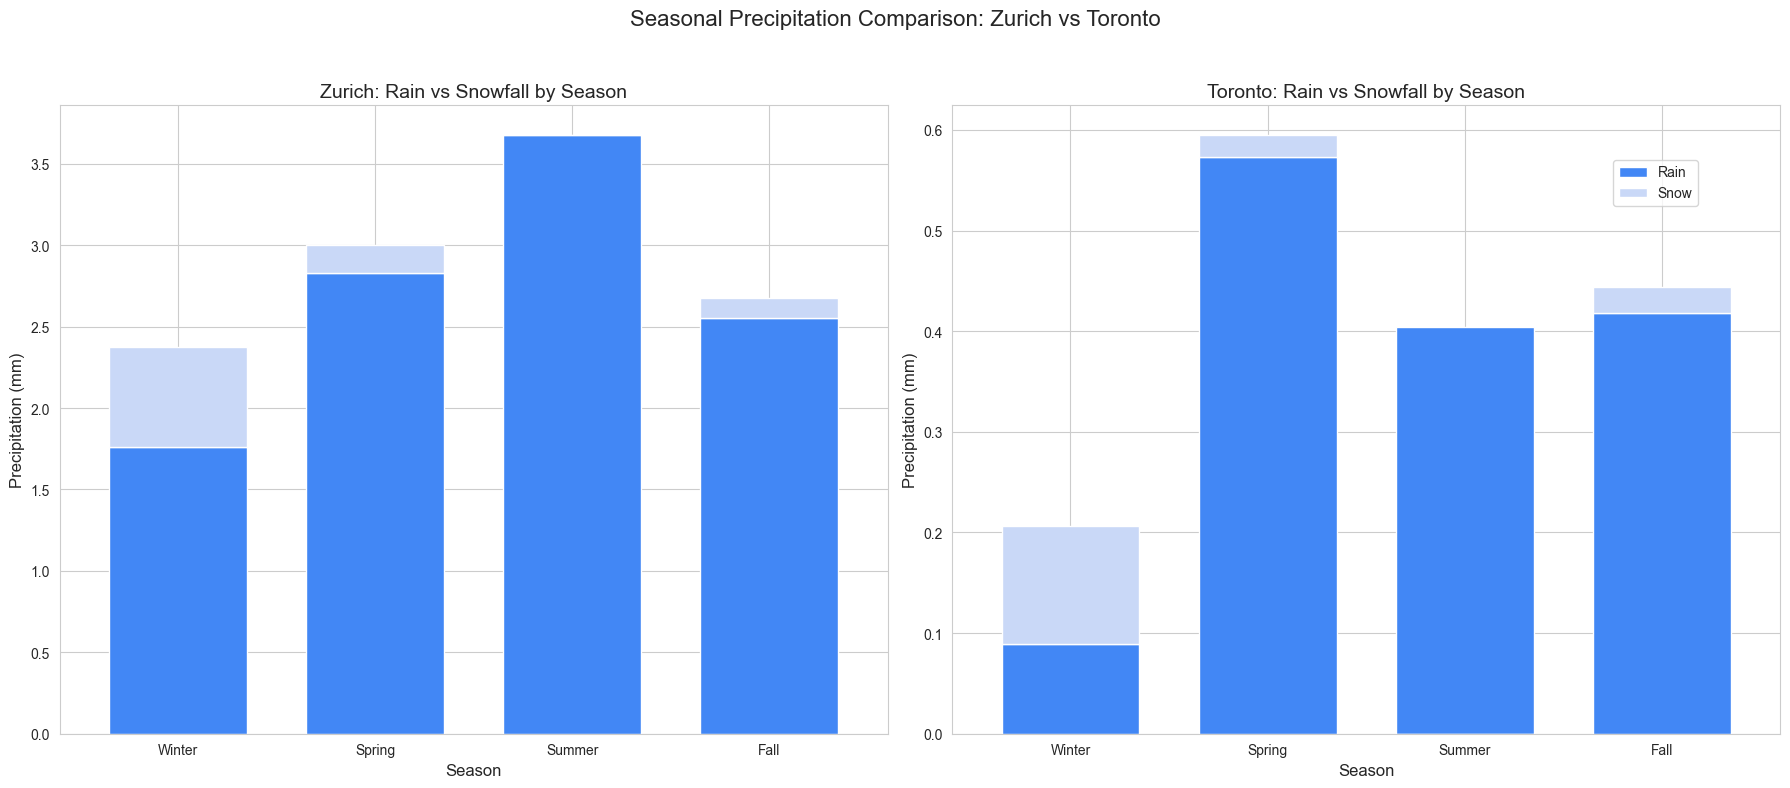

In [19]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Define colors for consistency
rain_color = '#4287f5'  # blue
snow_color = '#c9d8f7'  # light blue

# Stacked bar chart for Zurich
zurich_precip[['Rain', 'Snow']].plot(kind='bar', stacked=True, 
                                     color=[rain_color, snow_color], 
                                     ax=ax1, width=0.7, legend=False)
ax1.set_title('Zurich: Rain vs Snowfall by Season', fontsize=14)
ax1.set_xlabel('Season', fontsize=12)
ax1.set_ylabel('Precipitation (mm)', fontsize=12)
ax1.set_xticklabels(zurich_precip['Season'], rotation=0)

# Stacked bar chart for Toronto
toronto_precip[['Rain', 'Snow']].plot(kind='bar', stacked=True, 
                                      color=[rain_color, snow_color], 
                                      ax=ax2, width=0.7, legend=False)
ax2.set_title('Toronto: Rain vs Snowfall by Season', fontsize=14)
ax2.set_xlabel('Season', fontsize=12)
ax2.set_ylabel('Precipitation (mm)', fontsize=12)
ax2.set_xticklabels(toronto_precip['Season'], rotation=0)

# Add legend to the top right corner
fig.legend(['Rain', 'Snow'], loc='upper right', bbox_to_anchor=(0.95, 0.8))

plt.suptitle('Seasonal Precipitation Comparison: Zurich vs Toronto', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

From the chart it is clear that Zurich has significantly more precipitation than Toronto. Zürich tends get the most rain during the summer months while Toronto gets most of it's rain during the spring months. Interestingly both cities have the least amount of precipitation in winter with snow making up up a much biggger portion of the total.

## Monthly ET0 to Precipitation Ratio

In [ ]:
# Create a ratio comparison between ET0 and precipitation
merged_df['et0_precip_ratio_Zurich'] = merged_df['et0_fao_evapotranspiration_Zurich'] / (merged_df['precipitation_sum_Zurich'] + 0.1)  # Adding 0.1 to avoid division by zero
merged_df['et0_precip_ratio_Toronto'] = merged_df['et0_fao_evapotranspiration_Toronto'] / (merged_df['precipitation_sum_Toronto'] + 0.1)

# Group by month for the ratio
zurich_ratio_monthly = merged_df.groupby('month_name')['et0_precip_ratio_Zurich'].mean().reset_index()
toronto_ratio_monthly = merged_df.groupby('month_name')['et0_precip_ratio_Toronto'].mean().reset_index()

# Fix the column names in the DataFrame creation
ratio_monthly = pd.DataFrame({
    'Month': zurich_ratio_monthly['month_name'],
    'Zurich': zurich_ratio_monthly['et0_precip_ratio_Zurich'],
    'Toronto': toronto_ratio_monthly['et0_precip_ratio_Toronto']
})

# Change month to categorical and order
ratio_monthly['Month'] = pd.Categorical(ratio_monthly['Month'], categories=month_order, ordered=True)
ratio_monthly = ratio_monthly.sort_values('Month')

# Format data for plotting
ratio_monthly_melted = pd.melt(ratio_monthly, 
                               id_vars=['Month'],
                               value_vars=['Zurich', 'Toronto'],
                               var_name='City', 
                               value_name='ET0/Precipitation Ratio')

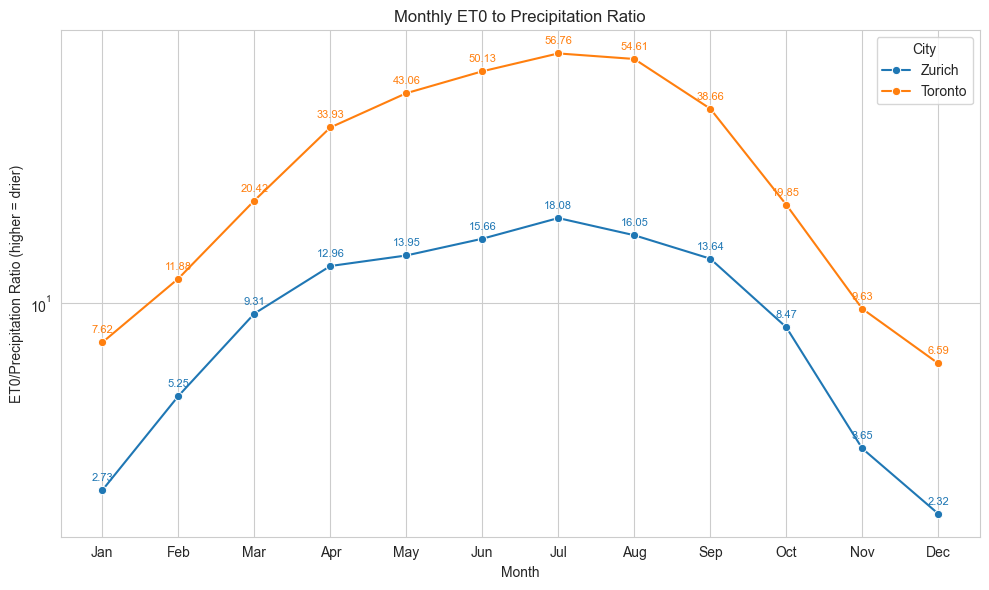

In [25]:
# Plot the chart
plt.figure(figsize=(10, 6))
ax = sns.lineplot(x='Month', y='ET0/Precipitation Ratio', hue='City', 
             data=ratio_monthly_melted, marker='o', palette=['#1f77b4', '#ff7f0e'])
plt.title('Monthly ET0 to Precipitation Ratio')
plt.xlabel('Month')
plt.ylabel('ET0/Precipitation Ratio (higher = drier)')
plt.legend(title='City')
plt.yscale('log')  # Log scale to handle wide range of ratios

# Add value labels to each point
for city, color in zip(['Zurich', 'Toronto'], ['#1f77b4', '#ff7f0e']):
    for i, row in ratio_monthly.iterrows():
        month = row['Month']
        value = row[city]
        # Position the text very close to each point
        y_offset = value * 1.05  # Just 5% above the point
        plt.text(month, y_offset, f'{value:.2f}', 
                 color=color, ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

ET0 represents the atmospheric demand for water - essentially how much water would evaporate from soil and transpire through plants under ideal conditions. 

Toronto has a higher ET0/precipitation ratio in summer months, indicating potentially drier conditions despite similar precipitation levels. Zurich tends to have higher ET0/precipitation ratios in winter, suggesting relatively drier winter conditions. Zurich has more consistent atmospheric moisture demand year-round, while Toronto likely experiences more intense summer drying conditions. Despite being at similar latitudes, the two cities experience different atmospheric moisture conditions.

## Research Question 3